# Exploratory Machine Learning models on the game of Pong
In this project, I will create the game of Pong, from scratch, and attempt to apply multiple machine learning approaches on it. I chose to do this since if I use a public dataset, I would just be reusing someone's data and replicating their results. Instead, I wanted to create my own dataset.

First, I create the game: 

There are two players (left and right paddle), and a ball that bounces at the box walls (up and down).

The ball moves in a linear motion with constant speed when in the middle of the box, reflects speed when it hits one of the wall edges, and reflects non-linearly when it hits a paddle (according to where it hits the paddle and its previous direction).

I coded two different AI for the left and right paddles:
  - The left paddle attempts to keep the ball within its length as long as the ball is within its side of the box (half the box). If the ball is on the other side, the left player moves the paddle to the middle, making it easier to reach all sides of the board when the ball comes back to their side of the box.
  - The right paddle attempts to keep the ball very close to the center of its length, there are some edge cases at the edges (where the paddle stops since it can't go outside the box). The right paddle follows the ball the entire time.

The ball has float values for its speed, which keep changing whenever a paddle hits it (due to non-linear reflection) but the measurements (the image seen) is a 128x192 image, therefore, the ball position is converted to an integer before outputting the frame. Finally, whenever a ball is reflected by a paddle, not only is there a non-linear function affecting its reflected speed, but also additive noise.

A game is played until one player scores or 1000 frames have passed. I created a game recorder object to record each game. Games are played and recorded indefinitely until 50 games are won (one player has scored). This is random, each game's ball has a random initial velocity, random initial position, and nonlinear paddle reflections. However, I noticed that on average, I need 100-150 total games at most for 50 games to be won.

# Models applied
I will attempt to implement multiple models, some have timeseries and some have CNNs, and some are chained models.

## For Estimating the ball's position and each paddle's position
I utilize a CNN-based model. The output could either be the position directly (linear - mse), or one-hot encoded coordinates since we know the image size (softmax - categorical crossentropy)

## For estimating the ball's velocity
This requires a timeseries, and not just two frames. Assume the ball's speed is 0.2 in the x direction. It will take 5 frames until the ball moves one pixel in the x direction. This will take its input from the ball position model!

## For detecting ball bounce
This is a boolean, 0 or 1. We will use the ball position model to detect this (sigmoid - binary creossentropy).

#Preamble

In [134]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Permute, AveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LayerNormalization, SimpleRNN
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D, LSTM, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# from google.colab.patches import cv2_imshow
early_stop = EarlyStopping(monitor='loss',patience=2,restore_best_weights=True)

# Class Creation (Game and Recorder)

In [2]:
class GameRecorder:
    def __init__(self,game):
        self.borders = [0,game.box_size[1]]
        self.bounce = []
        self.collision = []
        self.left_collision = []
        self.right_collision = [] # Conv2d -> Dense(sigmoid)
        self.ball_pos = [] # Conv2d -> Dense
        self.ball_vel = [] # ball_pos -> TimeSeries -> Dense (Nonlinear)
        self.left_pos = [] # Conv2d -> Dense
        self.right_pos = [] # Conv2d -> Dense
        self.left_vel = [] # left_pos -> TimeSeries -> Dense
        self.right_vel = [] # right_pos -> TimeSeries -> Dense
        self.gameOver = False
        self.frame_count = -1
        self.frames = []

    def save_states(self,game):
        self.frame_count+=1
        self.frames.append(game.board)
        self.bounce.append(game.bounce[1])
        self.collision.append(game.collision)
        self.left_collision.append(game.left_collision)
        self.right_collision.append(game.right_collision)
        self.ball_pos.append(game.ball_pos.copy())
        self.ball_vel.append(game.ball_speed.copy())
        self.left_pos.append(game.left_paddle_pos[1])
        self.right_pos.append(game.right_paddle_pos[1])
        self.left_vel.append(game.left_paddle_speed[1])
        self.right_vel.append(game.right_paddle_speed[1])
        self.gameOver = game.gameOver
class Pong:
    def __init__(self,randomize):
        self.box_size = (128,128+64)

        self.paddle_size = (4,20)
        self.left_paddle_pos = [0,(self.box_size[1]-self.paddle_size[1])//2]
        self.right_paddle_pos = [self.box_size[0]-self.paddle_size[0],(self.box_size[1]-self.paddle_size[1])//2]
        
        self.paddle_speed_mag = 2
        self.left_paddle_speed = [0,self.paddle_speed_mag]
        self.right_paddle_speed = [0,self.paddle_speed_mag]
        self.right_follow_margin = self.paddle_size[1]//4
        self.left_follow_margin = self.right_follow_margin//4

#         self.right_follow_margin = self.paddle_size[1]//4
#         self.left_follow_margin = self.right_follow_margin//4
#         self.max_reflection_range = [0.5,1.5]
        self.max_speed = 4
        self.eps = 0.1
        self.ball_size = (3,3)
        self.ball_pos = np.array([self.left_paddle_pos[0]+5,self.left_paddle_pos[1]],dtype=np.float64)
        self.ball_speed = np.array([2,2],dtype=np.float64)
        if randomize:
            self.ball_speed = np.array([np.random.random()*1.5+1.25,np.random.random()*1.5+1.25],dtype=np.float64)
            self.ball_pos = np.array([self.left_paddle_pos[0]+5,np.random.random()*(self.box_size[1]-self.ball_size[1]-10)+5],dtype=np.float64)
        self.init_speed = self.ball_speed.copy()
        self.collision = False
        self.left_collision = False
        self.right_collision = False
        self.saved_bounce = []
        self.saved_ball_speed = []
        self.saved_ball_pos = []
        self.gameOver = False
        self.bounce = [False,False]
    def check_collision_left(self):
        self.left_collision = self.ball_pos[0]<=self.left_paddle_pos[0]+self.paddle_size[0]\
                and self.ball_pos[1]<=self.paddle_size[1]+self.left_paddle_pos[1]\
                and self.ball_pos[1]+self.ball_size[1]>=self.left_paddle_pos[1]
        return self.left_collision
    def check_collision_right(self):
        self.right_collision = self.ball_pos[0]+self.ball_size[0]>=self.right_paddle_pos[0]\
                and self.ball_pos[1]<=self.paddle_size[1]+self.right_paddle_pos[1]\
                and self.ball_pos[1]+self.ball_size[1]>=self.right_paddle_pos[1]
        return self.right_collision
    
    def simulate_ball(self):
        self.bounce = [False,False]
#         if self.ball_pos[0]+self.ball_size[0]>=self.box_size[0] or self.ball_pos[0]<=0:
#             self.ball_speed[0] *= -1
#             bounce[0] = True
        self.collision = False
        paddle_collided,clip_pos = (self.left_paddle_pos,self.left_paddle_pos[0]+self.paddle_size[0]) if self.check_collision_left() else (False,0)
        paddle_collided,clip_pos = (self.right_paddle_pos,self.right_paddle_pos[0]-self.ball_size[0]) if self.check_collision_right() else (paddle_collided,clip_pos)

        if paddle_collided:
            self.collision = True
            self.ball_pos[0] = clip_pos
            
            reflection_ratio = self.ball_pos[1]+self.ball_size[1]//2 - (paddle_collided[1]+self.paddle_size[1]//2)
            reflection_ratio /= (self.paddle_size[1]//2)
            reflection_ratio *= 5*np.pi/12 #max angle
            
            self.ball_speed[0] = -np.sign(self.ball_speed[0])*round(self.init_speed[0]*np.cos(reflection_ratio),2)
            self.ball_speed[1] =  round(self.init_speed[1]*np.sin(reflection_ratio),2)

            self.ball_speed[0] = min(self.max_speed,round(self.ball_speed[0]+(np.random.random()*self.eps*np.sign(self.ball_speed[0])),2))
            self.ball_speed[1] = min(self.max_speed,round(self.ball_speed[1]+(np.random.random()*self.eps*np.sign(self.ball_speed[1])),2))
#             print(self.ball_pos,self.ball_speed)
#             self.ball_speed[0] *= -1

        if self.ball_pos[0]+self.ball_size[0]>=self.box_size[0] or self.ball_pos[0]<=0:
            self.gameOver = True
#             self.ball_speed[0] *= -1
#             bounce[0] = True
        
        if self.ball_pos[1]+self.ball_size[1]>=self.box_size[1] or self.ball_pos[1]<=0:
            self.ball_speed[1] *= -1
            self.bounce[1] = True
        self.saved_bounce.append(self.bounce)
        self.saved_ball_speed.append(self.ball_speed.copy())
        self.ball_pos += self.ball_speed
        self.saved_ball_pos.append(self.ball_pos.copy())
    def simulate_paddle_left(self):
#         print(self.right_paddle_pos[1],self.right_paddle_speed[1],self.ball_speed)
#         if self.left_paddle_pos[1]+self.paddle_size[1]>=self.box_size[1] or self.left_paddle_pos[1]<=0:
#             self.left_paddle_speed[1] *= -1
#         self.left_paddle_pos[1]+=self.left_paddle_speed[1]
        
        if self.ball_pos[0]<=self.box_size[0]//2:
            self.dist = np.sign(self.ball_pos[1]+self.ball_size[1]//2-(self.left_paddle_pos[1]+self.paddle_size[1]//2))
            if self.left_paddle_pos[1]+self.paddle_size[1]>=self.ball_pos[1]+self.ball_size[1] and self.left_paddle_pos[1]+self.left_follow_margin<=self.ball_pos[1]:
                return
            self.left_paddle_speed[1] = self.paddle_speed_mag*self.dist        
            if self.left_paddle_pos[1]+self.paddle_size[1]+self.left_paddle_speed[1]-self.left_follow_margin>=self.box_size[1] or self.left_paddle_pos[1]+self.left_paddle_speed[1]<=0:
                return
            self.left_paddle_pos[1] += self.left_paddle_speed[1]
        else:
            self.dist = np.sign(self.box_size[1]//2-(self.left_paddle_pos[1]+self.paddle_size[1]//2))
            self.left_paddle_speed[1] = self.paddle_speed_mag*self.dist 
            self.left_paddle_pos[1] += self.left_paddle_speed[1]
            
    def simulate_paddle_right(self):
        self.dist = np.sign(self.ball_pos[1]+self.ball_size[1]//2-(self.right_paddle_pos[1]+self.paddle_size[1]//2))
        if self.right_paddle_pos[1]+self.paddle_size[1]>=self.ball_pos[1]+self.ball_size[1] and self.right_paddle_pos[1]+self.right_follow_margin<=self.ball_pos[1]:
            return
        self.right_paddle_speed[1] = self.paddle_speed_mag*self.dist        
        if self.right_paddle_pos[1]+self.paddle_size[1]+self.right_paddle_speed[1]-self.right_follow_margin>=self.box_size[1] or self.right_paddle_pos[1]+self.right_paddle_speed[1]<=0:
            return
        self.right_paddle_pos[1] += self.right_paddle_speed[1]
    def draw_board(self):
        self.board = np.zeros(self.box_size, dtype=np.uint8)
        self.board[max(0,int(self.ball_pos[0])):max(0,int(self.ball_pos[0]))+self.ball_size[0],max(0,int(self.ball_pos[1])):max(0,int(self.ball_pos[1]))+self.ball_size[1]] = 255
        self.board[int(self.left_paddle_pos[0]):int(self.left_paddle_pos[0])+self.paddle_size[0],int(self.left_paddle_pos[1]):int(self.left_paddle_pos[1])+self.paddle_size[1]] = 255
        self.board[int(self.right_paddle_pos[0]):int(self.right_paddle_pos[0])+self.paddle_size[0],int(self.right_paddle_pos[1]):int(self.right_paddle_pos[1])+self.paddle_size[1]] = 255
#         self.board = cv2.putText(self.board.copy(), str(self.collision),(64,64),cv2.FONT_HERSHEY_SIMPLEX,0.3,255, 1, cv2.LINE_AA)
#         cv2.imshow('board',self.board)
#         k = cv2.waitKey(1)
#         if ord('q')==k:
#             self.gameOver = True
#         cv2.destroyAllWindows()

## Play and record games

In [3]:
import cv2
import numpy as np

# game.draw_board()
n_frames = 1000
n_games = 0
games_won = 0
games = []
while games_won<50:
    n_games+=1
    game = Pong(False)
    game.draw_board()
    recorder = GameRecorder(game)
    recorder.save_states(game)
    for frame_index in range(n_frames):
        game.simulate_ball()
        game.simulate_paddle_left()
        game.simulate_paddle_right()
        game.draw_board()
        recorder.save_states(game)
        if game.gameOver:break
    if game.gameOver:games_won +=1
    games.append(recorder)
print(f'game: {games_won}/{n_games}')
cv2.destroyAllWindows()

game: 50/101


# Ball Position Model

## Model 1: Conv2D(relu)->linear(mse)

In [244]:
n_conv_units = 4
n_sensors = 1
nOutputs = 2
image_height,image_width = games[0].frames[0].shape
ball_position_model = Sequential()
ball_position_model.add(Conv2D(filters = n_conv_units, 
                kernel_size = (5, 5),  #these are the spatial filter kernels
                activation = 'relu',
                #input_shape = (batch_size, predict_length, image_height, image_width, n_sensors*n_time_images),
                input_shape = (image_height, image_width,1),  #use when predict_length=1, batch_size=1
                padding = 'valid'))
ball_position_model.add(Flatten())  #so that the linear layer produces a single set of outputs
ball_position_model.add(Dense(nOutputs, activation='linear'))  #last layer will scale the output back up because average will be small
ball_position_model.compile(optimizer='adam', loss='mse')
ball_position_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 188, 4)       104       
                                                                 
 flatten_6 (Flatten)         (None, 93248)             0         
                                                                 
 dense_40 (Dense)            (None, 2)                 186498    
                                                                 
Total params: 186,602
Trainable params: 186,602
Non-trainable params: 0
_________________________________________________________________


Epoch 1/25
2104/2104 [==============================] - 276s 131ms/step - loss: 72.9661
Epoch 2/25
2104/2104 [==============================] - 286s 136ms/step - loss: 23.2684
Epoch 3/25
2104/2104 [==============================] - 284s 135ms/step - loss: 17.5706
Epoch 4/25
2104/2104 [==============================] - 285s 135ms/step - loss: 14.7723
Epoch 5/25
2104/2104 [==============================] - 288s 137ms/step - loss: 13.0560
Epoch 6/25
2104/2104 [==============================] - 286s 136ms/step - loss: 11.5225
Epoch 7/25
2104/2104 [==============================] - 284s 135ms/step - loss: 10.0848
Epoch 8/25
2104/2104 [==============================] - 287s 136ms/step - loss: 9.0544
Epoch 9/25
2104/2104 [==============================] - 285s 135ms/step - loss: 8.1837
Epoch 10/25
2104/2104 [==============================] - 284s 135ms/step - loss: 8.0191
Epoch 11/25
2104/2104 [==============================] - 288s 137ms/step - loss: 7.5076
Epoch 12/25
2104/2104 [===========

<AxesSubplot:>

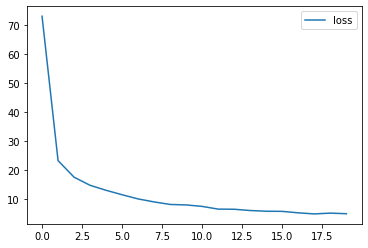

In [17]:
filepath="weights.ball_pos_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
ball_position_model.fit(x=np.array([frame for game in games for frame in game.frames]),y=np.array([pos for game in games for pos in game.ball_pos]), 
          epochs=25,
          callbacks=[early_stop,checkpoint],
          shuffle=True)
losses = pd.DataFrame(ball_position_model.history.history)
losses.plot()

In [246]:
ball_position_model.load_weights('weights.ball_pos_1.hdf5')
game_index = 10
frame_index = 200
print(np.array([games[game_index].frames[frame_index]]).shape)
pred = ball_position_model.predict(np.array([games[game_index].frames[frame_index]]))
print(np.round(pred))
print(np.array([pos/255.0 for game in games[10:11] for pos in game.ball_pos[200:201]]))
print(np.round(games[game_index].ball_pos[frame_index]))
cv2.imshow('sd',games[game_index].frames[frame_index])
cv2.waitKey(0)
cv2.destroyAllWindows()

(1, 128, 192)
1/1 [==============================] - 0s 27ms/step
[[102.  34.]]
[[0.39568627 0.12988235]]
[101.  33.]


##Model 2: Conv -> Dense

In [247]:
n_conv_units = 10
n_sensors = 1
nOutputs = 2
image_height,image_width = games[0].frames[0].shape
ball_position_model = Sequential()
ball_position_model.add(Conv2D(filters = n_conv_units, 
                kernel_size = (3, 3),  #these are the spatial filter kernels
                activation = 'relu',
                #input_shape = (batch_size, predict_length, image_height, image_width, n_sensors*n_time_images),
                input_shape = (image_height, image_width,1),  #use when predict_length=1, batch_size=1
                padding = 'same'))
ball_position_model.add(Flatten())  #so that the linear layer produces a single set of outputs
ball_position_model.add(Dense(nOutputs, activation='linear'))  #last layer will scale the output back up because average will be small
ball_position_model.compile(optimizer='adam', loss='mse')
ball_position_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 192, 10)      100       
                                                                 
 flatten_7 (Flatten)         (None, 245760)            0         
                                                                 
 dense_41 (Dense)            (None, 2)                 491522    
                                                                 
Total params: 491,622
Trainable params: 491,622
Non-trainable params: 0
_________________________________________________________________


In [25]:
# filepath="weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# ball_position_model.fit(x=np.array([frame for game in games for frame in game.frames]),y=np.array([pos for game in games for pos in game.ball_pos]), 
#           epochs=25,
#           callbacks=[early_stop,checkpoint],
#           shuffle=True)
# losses = pd.DataFrame(ball_position_model.history.history)
# losses.plot()

In [248]:
ball_position_model.load_weights('weights.best.hdf5')
game_index = 10
frame_index = 200
print(np.array([games[game_index].frames[frame_index]]).shape)
pred = ball_position_model.predict(np.array([games[game_index].frames[frame_index]]))
print(np.round(pred))
print(np.array([pos/255.0 for game in games[10:11] for pos in game.ball_pos[200:201]]))
print(np.round(games[game_index].ball_pos[frame_index]))
cv2.imshow('frame',games[game_index].frames[frame_index])
cv2.waitKey(0)
cv2.destroyAllWindows()

(1, 128, 192)
1/1 [==============================] - 0s 86ms/step
[[101.  35.]]
[[0.39568627 0.12988235]]
[101.  33.]


##Demonstrate output for a game

In [ ]:
game_chosen = games[0]
predicted_frames = []
video = cv2.VideoWriter('predicted_video.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20.0, (image_width,image_height))
for idx,image in enumerate(game_chosen.frames):
  predicted = ball_position_model.predict(np.array([image]))
  predicted = tuple([int(elem) for elem in predicted.flatten()])
  image = cv2.cvtColor((image.copy()).astype('uint8'),cv2.COLOR_GRAY2BGR)
  image = cv2.rectangle(image,(predicted[1],predicted[0]),(predicted[1]+3,predicted[0]+3),(0,255,0),-1)
  video.write(image)
print(len(game_chosen.frames))
cv2.destroyAllWindows()
video.release()


# Left Paddle

## Model 1: One-hot Encoding, Conv2D, MaxPooling2D, Categorical Crossentropy

### Create Dataset


In [62]:
filepath="weights.left_paddle_model_onehot.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
all_positions = list(range(2,173,2))
x_left = []
y_left = []
for game in games:
  for idx,left_pos in enumerate(game.left_pos):
    x_left.append(np.expand_dims(game.frames[idx],axis=2))
    one_hot = np.zeros((len(all_positions),1))
    one_hot[int(left_pos//2 - 1)] = 1
    y_left.append(one_hot)
p = np.random.permutation(len(x_left))
x_left = np.array(x_left)[p]
y_left = np.array(y_left)[p]

In [63]:
print(x_left.shape,y_left.shape)

(67306, 128, 192, 1) (67306, 86, 1)


### Build Model

In [64]:
nOutputs = 1
left_position_model = Sequential()
left_position_model.add(Conv2D(filters = 10, 
                kernel_size = (5, 5),
                activation = 'relu',
                input_shape = (image_height, image_width,1),
                padding = 'valid'))
left_position_model.add(MaxPooling2D((image_height-5,1)))
left_position_model.add(Flatten())
left_position_model.add(Dense(86, activation='softmax'))
left_position_model.compile(optimizer='adam', loss='categorical_crossentropy')
left_position_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 188, 10)      260       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 188, 10)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1880)              0         
                                                                 
 dense_4 (Dense)             (None, 86)                161766    
                                                                 
Total params: 162,026
Trainable params: 162,026
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/5
2104/2104 [==============================] - 397s 188ms/step - loss: 0.6141
Epoch 2/5
2104/2104 [==============================] - 391s 186ms/step - loss: 0.0024
Epoch 3/5
2104/2104 [==============================] - 403s 191ms/step - loss: 0.0055
Epoch 4/5
2104/2104 [==============================] - 384s 183ms/step - loss: 1.3727e-06
Epoch 5/5
2104/2104 [==============================] - 404s 192ms/step - loss: 2.4723e-08


<AxesSubplot:>

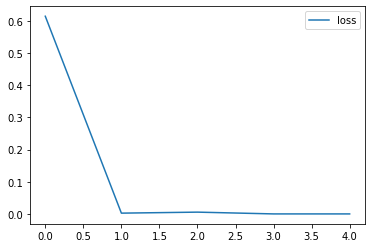

In [65]:
# left_position_model.load_weights('weights.left_paddle_model_onehot.hdf5')
left_position_model.fit(x=x_left,y=y_left, 
          epochs=5,
          callbacks=[early_stop,checkpoint])
losses = pd.DataFrame(left_position_model.history.history)
losses.plot()

### Visualizing the layers!

1/1 [==============================] - 0s 55ms/step
Conv2D Output
True Position 42 Predicted Position 42
Max Pooling Output
True Position 42 Predicted Position 42
True Position 42 Predicted Position 42
Dense Output
True Position 42 Predicted Position 42


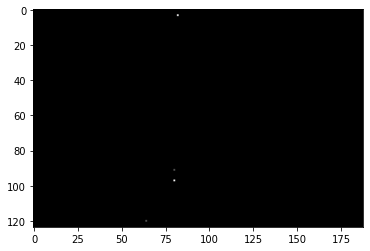

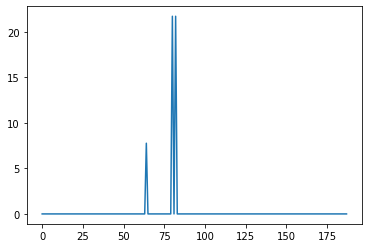

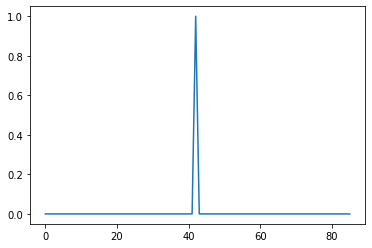

In [75]:
successive_outputs = [layer.output for layer in left_position_model.layers]
visualization_model = Model(inputs = left_position_model.input, outputs = successive_outputs)

#Load the input image
x = np.array([x_left[0]])

successive_feature_maps = visualization_model.predict(x)

# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in left_position_model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
  if 'max_pooling2d' in layer_name:
    print('Max Pooling Output')
    plt.figure()
    plt.plot(feature_map[0,0,:,0])
  elif 'conv2d' in layer_name:
    print('Conv2D Output')
    plt.figure()
    plt.imshow(feature_map[0,:,:,0],cmap='gray' )
  elif 'dense' in layer_name:
    print('Dense Output')
    plt.figure()
    plt.plot(feature_map[0,:])
  print('True Position',np.argmax(y_left[0]),'Predicted Position',np.argmax(successive_feature_maps[-1]))

### Visualizing the filter
Since we forced the model to learn only one convolution filter, it has to create a filter that matches really well with the input image to extract a paddle shape. We can sort of see this in the image below, where the image attempts to find a stripe corresponding to the paddle. 

Since the right and left paddles are the same shape, what differentiates them (if doing convolution only), is their proximity to the edges. This is why I made the padding 'valid', so that no additional zeros are added, allowing for a filter that works for the left paddle, but not right one.

I believe that the bottom and right pixels are almost the same weight, (which probably is removing that part of the image), making the filter asymmetric and creating a filter for the left paddle only instead of the right paddle. This could also be analyzed as trying to filter out the ball (3x3) shape. 

The relu activation function lets the neural network either accept th convolution sum or reject it (by sliding the relu using the bias).

I added in a MaxPooling2D layer to collapse the image onto the dimension we're looking for, giving the maximum value across it. For example, if the filter was a (4,2) where each row is [1,1,0,0], then we'll get a maximum value across the entire paddle length. This will show up as a rect after max pooling. Then, all we need is to get the start (rising edge), and that is the left paddle coordinate.

 However, since during the game, the paddle y positions can overlap, this would lead to windows where the left paddle coordinate is lost in the middle. This is why a more unique filter should be applied to detect only the left paddle, where the left paddle coordinate shows as a spike.

conv2d_14 (5, 5, 1, 1)


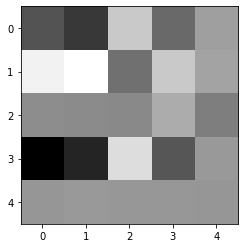

In [95]:
for layer in left_position_model.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        # print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            plt.figure()
            plt.imshow(filt[:,:,0],cmap='gray')
            # ax.set_xticks([])
            # ax.set_yticks([])
            # plt.imshow()
            filter_cnt+=1
        plt.show()

## Model2: Conv2D + MSE

### Create model
One 5x5 filter, then directly dense to 1 unit.

In [232]:
nOutputs = 1
left_position_model = Sequential()
left_position_model.add(Conv2D(filters = 1, 
                kernel_size = (5, 5),
                activation = 'relu',
                input_shape = (image_height, image_width,1),
                padding = 'valid'))
left_position_model.add(Flatten())
left_position_model.add(Dense(1))
left_position_model.compile(optimizer='adam', loss='mse')
left_position_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 188, 1)       26        
                                                                 
 flatten_3 (Flatten)         (None, 23312)             0         
                                                                 
 dense_37 (Dense)            (None, 1)                 23313     
                                                                 
Total params: 23,339
Trainable params: 23,339
Non-trainable params: 0
_________________________________________________________________


### Training

In [233]:
left_position_model.load_weights('weights.left_paddle_model_mse.hdf5')
# filepath="weights.left_paddle_model_mse.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# left_position_model.fit(x=np.array([frame for game in games for frame in game.frames]),y=np.array([pos for game in games for pos in game.left_pos]), 
#           epochs=25,
#           callbacks=[early_stop,checkpoint],
#           shuffle=True)
# losses = pd.DataFrame(left_position_model.history.history)
# losses.plot()

###Visualizing layer outputs!

1/1 [==============================] - 0s 126ms/step
True Position 86.0 , Predicted Position 86.55534
1/1 [==============================] - 0s 35ms/step
True Position 122.0 , Predicted Position 122.194916
1/1 [==============================] - 0s 26ms/step
True Position 122.0 , Predicted Position 122.84125
1/1 [==============================] - 0s 23ms/step
True Position 20.0 , Predicted Position 19.681131
1/1 [==============================] - 0s 24ms/step
True Position 86 , Predicted Position 86.336815
1/1 [==============================] - 0s 23ms/step
True Position 120.0 , Predicted Position 120.15023
1/1 [==============================] - 0s 24ms/step
True Position 100.0 , Predicted Position 100.44467
1/1 [==============================] - 0s 23ms/step
True Position 122.0 , Predicted Position 121.57606
1/1 [==============================] - 0s 25ms/step
True Position 98.0 , Predicted Position 98.459236


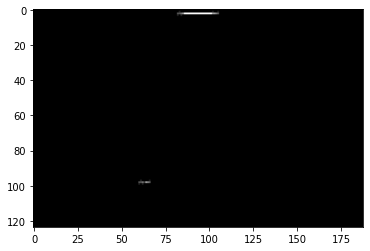

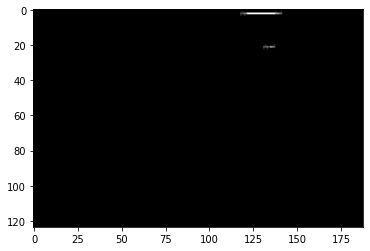

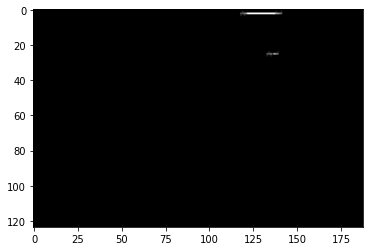

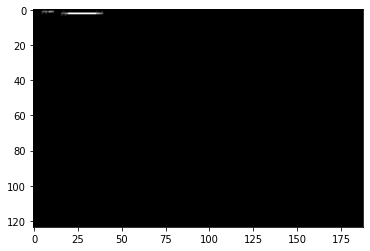

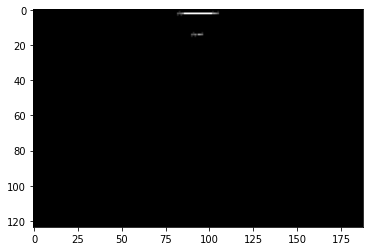

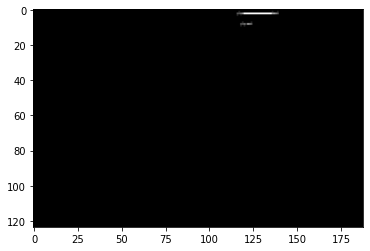

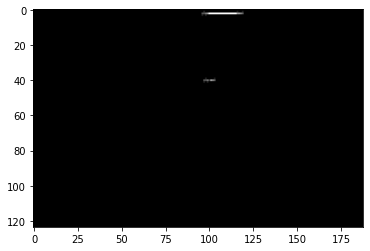

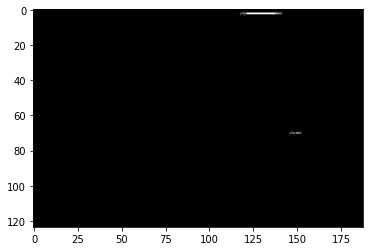

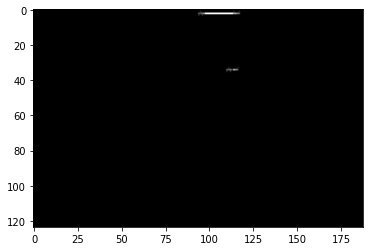

In [235]:
successive_outputs = [layer.output for layer in left_position_model.layers]
visualization_model = Model(inputs = left_position_model.input, outputs = successive_outputs)

n_games = 3
n_images = 3
#Load the input image
for _ in range(n_games):
  game_index = np.random.randint(len(games))
  for _ in range(n_images):
    frame_index = np.random.randint(len(games[game_index].frames))
    x = np.array([games[game_index].frames[frame_index]])

    successive_feature_maps = visualization_model.predict(x)

    # Retrieve are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in left_position_model.layers]
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
      if 'conv2d' in layer_name:
        plt.figure()
        plt.imshow(feature_map[0,:,:,0],cmap='gray' )

    print('True Position',games[game_index].left_pos[frame_index],', Predicted Position',successive_feature_maps[-1][0][0])

###Visualiziing the filter

conv2d_14 (5, 5, 1, 1)


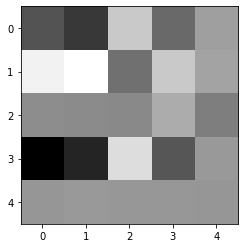

In [112]:
for layer in left_position_model.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        # print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            plt.figure()
            plt.imshow(filt[:,:,0],cmap='gray')
            # ax.set_xticks([])
            # ax.set_yticks([])
            # plt.imshow()
            filter_cnt+=1
        plt.show()

# Right Paddle
The second model performed much better, though trained slower then the first model. We will use that.

## Create model
One 5x5 filter, then directly dense to 1 unit.

In [236]:
nOutputs = 1
image_height,image_width = games[0].frames[0].shape
right_position_model = Sequential()
right_position_model.add(Conv2D(filters = 1, 
                kernel_size = (5, 5),
                activation = 'relu',
                input_shape = (image_height, image_width,1),
                padding = 'valid'))
right_position_model.add(Flatten())
right_position_model.add(Dense(1))
right_position_model.compile(optimizer='adam', loss='mse')
right_position_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 188, 1)       26        
                                                                 
 flatten_4 (Flatten)         (None, 23312)             0         
                                                                 
 dense_38 (Dense)            (None, 1)                 23313     
                                                                 
Total params: 23,339
Trainable params: 23,339
Non-trainable params: 0
_________________________________________________________________


## Training

In [237]:
right_position_model.load_weights('weights.right_paddle_model_mse.hdf5')
# filepath="weights.right_paddle_model_mse.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# right_position_model.fit(x=np.array([frame for game in games for frame in game.frames]),y=np.array([pos for game in games for pos in game.right_pos]), 
#           epochs=20,
#           callbacks=[early_stop,checkpoint],
#           shuffle=True)
# losses = pd.DataFrame(right_position_model.history.history)
# losses.plot()

##Visualizing layer outputs!

1/1 [==============================] - 0s 80ms/step
True Position 122.0 , Predicted Position 122.02553
1/1 [==============================] - 0s 23ms/step
True Position 128.0 , Predicted Position 128.60164
1/1 [==============================] - 0s 24ms/step
True Position 54.0 , Predicted Position 53.670403
1/1 [==============================] - 0s 25ms/step
True Position 80.0 , Predicted Position 80.73929
1/1 [==============================] - 0s 31ms/step
True Position 108.0 , Predicted Position 107.69644
1/1 [==============================] - 0s 28ms/step
True Position 136.0 , Predicted Position 135.65305
1/1 [==============================] - 0s 20ms/step
True Position 54.0 , Predicted Position 53.99037
1/1 [==============================] - 0s 24ms/step
True Position 32.0 , Predicted Position 32.08349
1/1 [==============================] - 0s 36ms/step
True Position 58.0 , Predicted Position 57.42079


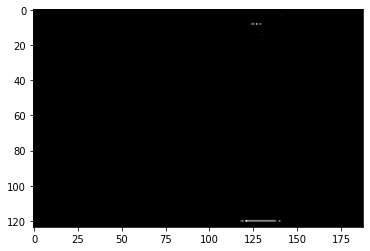

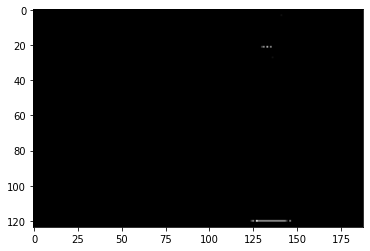

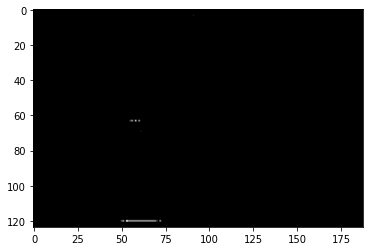

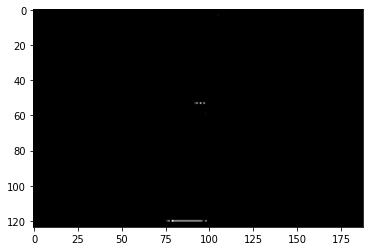

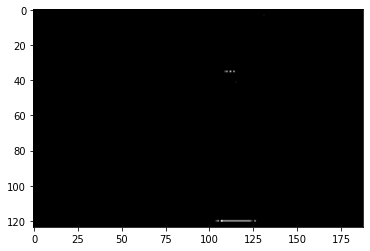

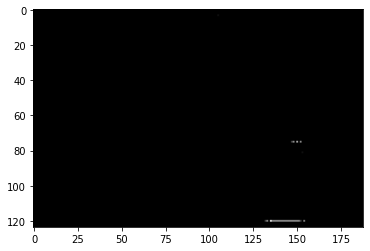

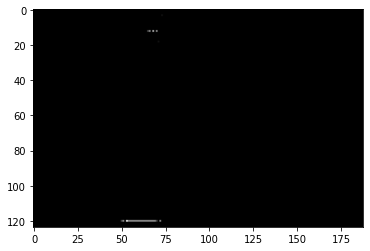

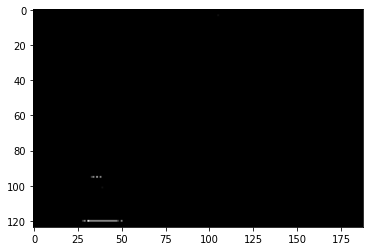

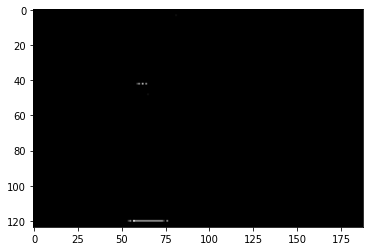

In [238]:
successive_outputs = [layer.output for layer in right_position_model.layers]
visualization_model = Model(inputs = right_position_model.input, outputs = successive_outputs)

n_games = 3
n_images = 3
#Load the input image
for _ in range(n_games):
  game_index = np.random.randint(len(games))
  for _ in range(n_images):
    frame_index = np.random.randint(len(games[game_index].frames))
    x = np.array([games[game_index].frames[frame_index]])

    successive_feature_maps = visualization_model.predict(x)

    # Retrieve are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in right_position_model.layers]
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
      if 'conv2d' in layer_name:
        plt.figure()
        plt.imshow(feature_map[0,:,:,0],cmap='gray' )

    print('True Position',games[game_index].right_pos[frame_index],', Predicted Position',successive_feature_maps[-1][0][0])

##Visualiziing the filter

conv2d (5, 5, 1, 1)


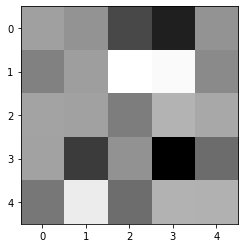

In [11]:
for layer in right_position_model.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        # print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            plt.figure()
            plt.imshow(filt[:,:,0],cmap='gray')
            # ax.set_xticks([])
            # ax.set_yticks([])
            # plt.imshow()
            filter_cnt+=1
        plt.show()

In [46]:
x = []
y = []
predict_length = 3
for game in games:
  for idx,frame in enumerate(game.frames[2:]):
    idx = idx+2
    if game.collision[idx] or game.bounce[idx]:continue
    x.append(np.array(game.ball_pos[idx-predict_length:idx]).flatten())
    y.append(np.array([game.ball_vel[idx]]).flatten())
x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(68369, 6) (68369, 2)


In [54]:
ball_velocity_model = Sequential()
ball_velocity_model.add(Dense(2, activation='linear',input_shape = (6,)))
ball_velocity_model.compile(optimizer='adam', loss='mse')
ball_velocity_model.summary()
plot_model(ball_velocity_model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 2)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<AxesSubplot:>

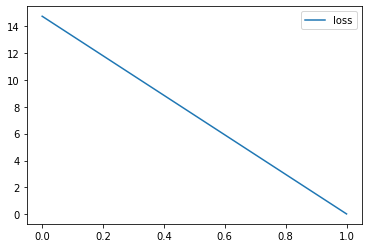

In [57]:
history = ball_velocity_model.fit(x,y,batch_size = 1,verbose=1,epochs=2)
losses = pd.DataFrame(history.history)
losses.plot()

In [89]:
x = []
y = []
predict_length = 2
for game in games:
  for idx,frame in enumerate(game.frames[2:]):
    idx = idx+2
    if game.collision[idx] or not game.bounce[idx]:continue
    x.append(np.array(game.ball_pos[idx-predict_length:idx]).flatten())
    y.append(np.array([game.ball_vel[idx]]).flatten())
x = np.array(x)/2.0
y = np.array(y)/2.0
print(x.shape,y.shape)

(574, 4) (574, 2)


In [90]:
print(x[0],y[0])

[1. 1. 1. 1.] [ 1. -1.]


In [96]:
ball_velocity_model = Sequential()
ball_velocity_model.add(Dense(2, activation='linear',input_shape = (4,)))
ball_velocity_model.compile(optimizer='adam', loss='mse')
ball_velocity_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
574/574 [==============================] - 1s 959us/step - loss: 0.4618
Epoch 2/50
574/574 [==============================] - 1s 947us/step - loss: 0.0829
Epoch 3/50
574/574 [==============================] - 1s 993us/step - loss: 0.0153
Epoch 4/50
574/574 [==============================] - 1s 934us/step - loss: 0.0053
Epoch 5/50
574/574 [==============================] - 1s 1ms/step - loss: 0.0042
Epoch 6/50
574/574 [==============================] - 1s 953us/step - loss: 0.0039
Epoch 7/50
574/574 [==============================] - 1s 949us/step - loss: 0.0036
Epoch 8/50
574/574 [==============================] - 1s 946us/step - loss: 0.0034
Epoch 9/50
574/574 [==============================] - 1s 1ms/step - loss: 0.0031
Epoch 10/50
574/574 [==============================] - 1s 1ms/step - loss: 0.0028
Epoch 11/50
574/574 [==============================] - 1s 966us/step - loss: 0.0026
Epoch 12/50
574/574 [==============================] - 1s 971us/step - loss: 0.0023
Epoch 1

<AxesSubplot:>

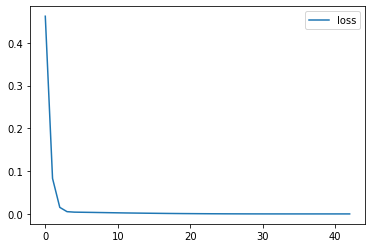

In [97]:
history = ball_velocity_model.fit(x,y,batch_size = 1,verbose=1,epochs=50,callbacks=[early_stop])
losses = pd.DataFrame(history.history)
losses.plot()

In [101]:
print(ball_velocity_model.predict(np.array([x[123]]))*2)
print(y[123]*2)

1/1 [==============================] - 0s 26ms/step
[[1.4199747 1.519763 ]]
[1.42 1.52]


In [124]:
x = []
y = []
predict_length = 2
for game in games:
  for idx,frame in enumerate(game.frames[2:]):
    idx = idx+2
    if not game.left_collision[idx]:continue
    x.append(np.array([game.ball_pos[idx-1][1]/128.0,game.left_pos[idx-1]/128.0]).flatten())
    y.append(np.array([game.ball_vel[idx]]).flatten())
x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(346, 2) (346, 2)


In [115]:
ball_velocity_model = Sequential()
ball_velocity_model.add(Dense(10, activation='sigmoid',input_shape = (2,)))
ball_velocity_model.add(Dense(10, activation='sigmoid'))
ball_velocity_model.add(Dense(2, activation='linear'))
ball_velocity_model.compile(optimizer='adam', loss='mse')
ball_velocity_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10)                30        
                                                                 
 dense_15 (Dense)            (None, 10)                110       
                                                                 
 dense_16 (Dense)            (None, 2)                 22        
                                                                 
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
346/346 [==============================] - 1s 1ms/step - loss: 1.2074
Epoch 2/50
346/346 [==============================] - 0s 1ms/step - loss: 0.6133
Epoch 3/50
346/346 [==============================] - 0s 1ms/step - loss: 0.5826
Epoch 4/50
346/346 [==============================] - 0s 1ms/step - loss: 0.5446
Epoch 5/50
346/346 [==============================] - 0s 1ms/step - loss: 0.4931
Epoch 6/50
346/346 [==============================] - 0s 1ms/step - loss: 0.4192
Epoch 7/50
346/346 [==============================] - 0s 1ms/step - loss: 0.3418
Epoch 8/50
346/346 [==============================] - 0s 1ms/step - loss: 0.2596
Epoch 9/50
346/346 [==============================] - 0s 1ms/step - loss: 0.1940
Epoch 10/50
346/346 [==============================] - 0s 1ms/step - loss: 0.1476
Epoch 11/50
346/346 [==============================] - 0s 1ms/step - loss: 0.1191
Epoch 12/50
346/346 [==============================] - 0s 1ms/step - loss: 0.1029
Epoch 13/50
346/346 [====

<AxesSubplot:>

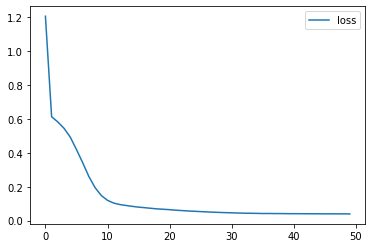

In [116]:
history = ball_velocity_model.fit(x,y,batch_size = 1,verbose=1,epochs=50,callbacks=[early_stop])
losses = pd.DataFrame(history.history)
losses.plot()

In [122]:
indices = []
for gidx,game in enumerate(games):
  for idx,frame in enumerate(game.frames[2:]):
    idx = idx+2
    if not game.left_collision[idx]:continue
    indices.append((gidx,idx))
print(indices[:10])

game_index = 1
frame_index = 736
x_test = np.array([games[game_index].ball_pos[frame_index-1][1]/128.0,games[game_index].left_pos[frame_index-1]/128.0]).flatten()
print(ball_velocity_model.predict(np.array([x_test])))
print(games[game_index].ball_vel[frame_index])

[(0, 121), (0, 260), (0, 632), (0, 805), (0, 942), (1, 122), (1, 260), (1, 383), (1, 544), (1, 736)]
1/1 [==============================] - 0s 20ms/step
[[ 1.1518178 -1.6719587]]
[ 1.12 -1.77]


In [125]:
predicted = ball_velocity_model.predict(x)
print(predicted.shape,y.shape)


11/11 [==============================] - 0s 1ms/step
(346, 2) (346, 2)


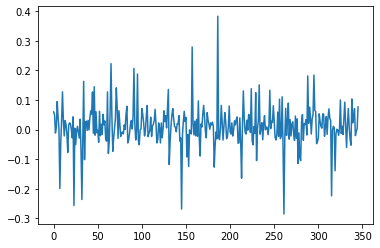

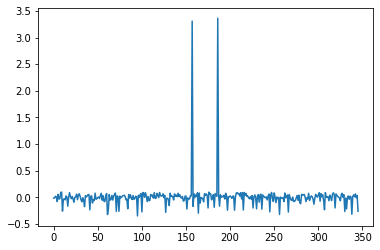

In [130]:
plt.figure()
plt.plot(predicted[:,0]-y[:,0])
# plt.plot(y[:,0])
plt.figure()
plt.plot(predicted[:,1]-y[:,1])
# plt.plot(])

In [177]:
free_x = []
bounce_x = []
collided_x = []
free_y = []
bounce_y = []
collided_y = []

total_examples = 5000

for game in games:
  for idx,frame in enumerate(game.frames[2:]):
    idx = idx+2
    if game.bounce[idx]:
      bounce_x.append(np.array([game.ball_pos[idx][0],game.ball_pos[idx][1],game.right_pos[idx],game.left_pos[idx],3,128.0,0.0]).flatten())
      bounce_y.append(0)
    elif game.collision[idx]:
      collided_x.append(np.array([game.ball_pos[idx][0],game.ball_pos[idx][1],game.right_pos[idx],game.left_pos[idx],3,128.0,0.0]).flatten())
      collided_y.append(1)
    else:
      free_x.append(np.array([game.ball_pos[idx][0],game.ball_pos[idx][1],game.right_pos[idx],game.left_pos[idx],3,128.0,0.0]).flatten())
      free_y.append(2)
free_x = np.array(free_x)
free_y = np.array(free_y)
bounce_x = np.array(bounce_x)
bounce_y = np.array(bounce_y)
collided_x = np.array(collided_x)
collided_y = np.array(collided_y)

print(free_x.shape,free_y.shape,bounce_x.shape,bounce_y.shape,collided_x.shape,collided_y.shape)

(68369, 7) (68369,) (578, 7) (578,) (757, 7) (757,)


In [178]:
free_idx = np.random.randint(free_x.shape[0],size=total_examples)
bounce_idx = np.resize(np.arange(bounce_x.shape[0]),total_examples)
collided_idx = np.resize(np.arange(collided_x.shape[0]),total_examples)
print(bounce_idx,bounce_idx.shape,collided_idx,collided_idx.shape)

[  0   1   2 ... 373 374 375] (5000,) [  0   1   2 ... 455 456 457] (5000,)


In [278]:

x = np.array([free_x[free_idx,:],bounce_x[bounce_idx,:],collided_x[collided_idx,:]]).reshape((3*5000,7))
y = np.array([free_y[free_idx]]+[bounce_y[bounce_idx]]+[collided_y[collided_idx]]).flatten()
print(x.shape,y.shape)

(15000, 7) (15000,)


In [195]:
ball_state_classification_model = Sequential()
ball_state_classification_model.add(Dense(10, activation='sigmoid',input_shape = (7,)))
ball_state_classification_model.add(Dense(10, activation='relu'))
ball_state_classification_model.add(Dense(3, activation='softmax'))
ball_state_classification_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy())
ball_state_classification_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 10)                80        
                                                                 
 dense_33 (Dense)            (None, 10)                110       
                                                                 
 dense_34 (Dense)            (None, 3)                 33        
                                                                 
Total params: 223
Trainable params: 223
Non-trainable params: 0
_________________________________________________________________


Epoch 1/25
15000/15000 [==============================] - 17s 1ms/step - loss: 0.7730
Epoch 2/25
15000/15000 [==============================] - 16s 1ms/step - loss: 0.6079
Epoch 3/25
15000/15000 [==============================] - 17s 1ms/step - loss: 0.5049
Epoch 4/25
15000/15000 [==============================] - 16s 1ms/step - loss: 0.4772
Epoch 5/25
15000/15000 [==============================] - 20s 1ms/step - loss: 0.4635
Epoch 6/25
15000/15000 [==============================] - 16s 1ms/step - loss: 0.5640
Epoch 7/25
15000/15000 [==============================] - 16s 1ms/step - loss: 0.4099
Epoch 8/25
15000/15000 [==============================] - 17s 1ms/step - loss: 0.2270
Epoch 9/25
15000/15000 [==============================] - 16s 1ms/step - loss: 0.2034
Epoch 10/25
15000/15000 [==============================] - 17s 1ms/step - loss: 0.1988
Epoch 11/25
15000/15000 [==============================] - 15s 1ms/step - loss: 0.1960
Epoch 12/25
15000/15000 [===========================

<AxesSubplot:>

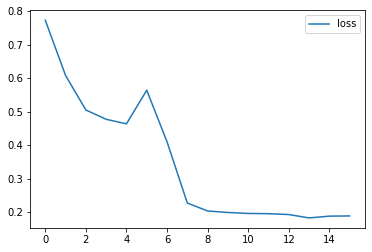

In [196]:
history = ball_state_classification_model.fit(x,y,batch_size = 1,verbose=1,epochs=25,callbacks=[early_stop],shuffle=True)
losses = pd.DataFrame(history.history)
losses.plot()

469/469 [==============================] - 1s 1ms/step


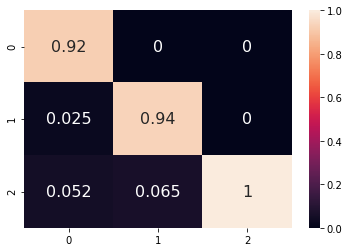

In [225]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

pred = ball_state_classification_model.predict(x)
result = confusion_matrix(y, np.argmax(pred,axis=1) , normalize='pred')
sn.heatmap(result, annot=True, annot_kws={"size": 16}) # font size
plt.show()
